In [1]:
import pandas as pd

# 데이터를 읽어봅시다.
train_data = pd.read_table('./sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('./sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab('C:/mecab/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- torch.nn.utils.rnn.pad_sequence 를 활용한 패딩 추가

In [5]:
# 모델 학습 전에 pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일해야 함
# 문장 최대 길이인 maxlen의 값 설정도 중요 -> 데이터셋의 분포 확인

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다.')

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473816
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다.


In [6]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence

def pad_sequences(data, maxlen, padding='pre', pad_value=0):
    """
    maxlen: 패딩 후 시퀀스 길이
    padding: 'pre'로 앞에 채우기
    pad_value: 패딩에 사용할 값
    """
    # 리스트를 torch.tensor로 변환
    tensor_data = [torch.tensor(seq, dtype=torch.long) for seq in data]

    # pad_sequence는 기본적으로 post-padding
    padded = pad_sequence(tensor_data, batch_first=True, padding_value=pad_value)

    # 지정된 maxlen보다 긴 경우 자르기
    if padded.size(1) > maxlen:
        padded = padded[:, :maxlen]
    # 짧으면 pre/post 방식에 맞춰 다시 패딩
    elif padded.size(1) < maxlen:
        diff = maxlen - padded.size(1)
        if padding == 'pre':
            padded = torch.cat([torch.full((padded.size(0), diff), pad_value, dtype=torch.long), padded], dim=1)
        else:  # post
            padded = torch.cat([padded, torch.full((padded.size(0), diff), pad_value, dtype=torch.long)], dim=1)
    
    return padded.numpy()


X_train_padded = pad_sequences(X_train, maxlen)
X_test_padded = pad_sequences(X_test, maxlen)

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)

print(X_train_tensor.shape)


torch.Size([146182, 41])


X_train tensor의 size를 확인해보니 maxlen으로 설정한 41로 크기가 잘 조정된 걸 확인할 수 있다

# 4) 모델 구성 및 validation set 구성

In [32]:
import torch.nn as nn
import torch.nn.functional as F

vocab_size = len(word_to_index)+3
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 128, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = len(word_to_index)+3
word_vector_dim = 128   
model = Model_1(vocab_size, word_vector_dim)

print(model)

Model_1(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
# validation set 30000 분리
X_val = X_train_tensor[:30000]
y_val = y_train[:30000]

# validation set을 제외한 나머지 건
partial_X_train = X_train_tensor[30000:]
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

torch.Size([116182, 41])
(116182,)


In [9]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 5   # 5부터 이격이 크게 벌어짐
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\3255727272.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\3255727272.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.long)


Epoch 1/5 - Train Loss: 0.6461, Train Accuracy: 0.5809 - Validation Loss: 0.4601, Validation Accuracy: 0.7856
Epoch 2/5 - Train Loss: 0.3948, Train Accuracy: 0.8214 - Validation Loss: 0.3641, Validation Accuracy: 0.8382
Epoch 3/5 - Train Loss: 0.3239, Train Accuracy: 0.8597 - Validation Loss: 0.3364, Validation Accuracy: 0.8529
Epoch 4/5 - Train Loss: 0.2842, Train Accuracy: 0.8807 - Validation Loss: 0.3307, Validation Accuracy: 0.8569
Epoch 5/5 - Train Loss: 0.2515, Train Accuracy: 0.8976 - Validation Loss: 0.3424, Validation Accuracy: 0.8584


In [10]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3530, Test Accuracy: 0.8534


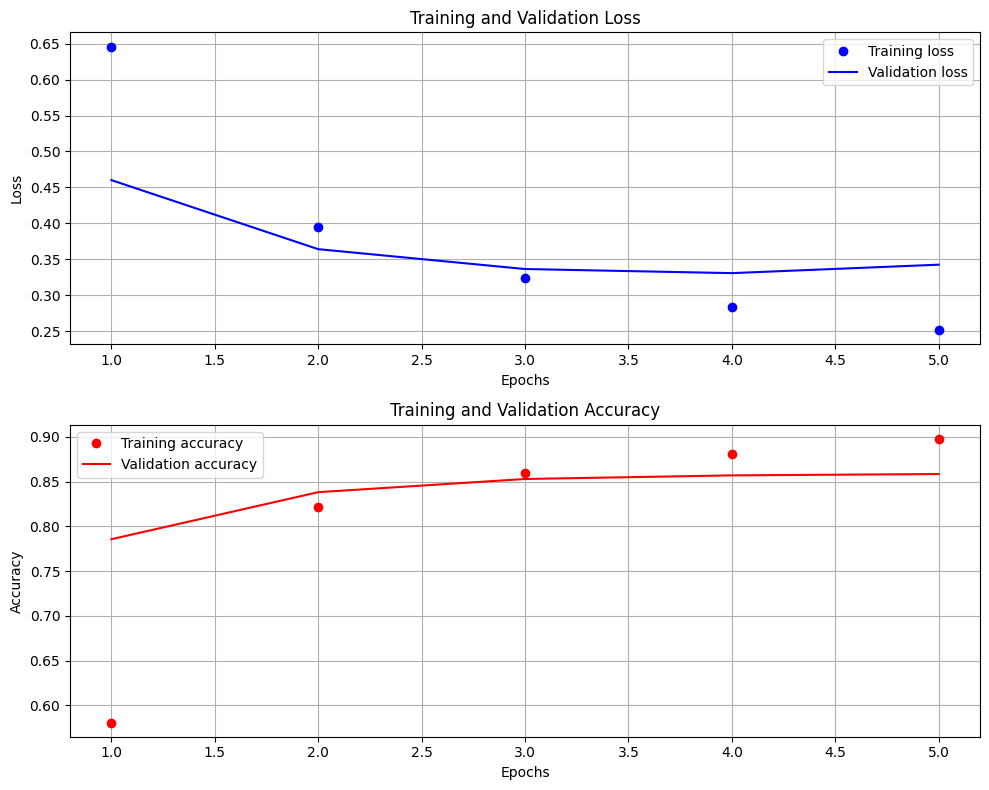

In [11]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 8))  # 전체 Figure 크기 설정

# (1) Loss 그래프
plt.subplot(2, 1, 1)  
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy 그래프
plt.subplot(2, 1, 2)  
plt.plot(epochs_range, train_accs, 'ro', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()  # 그래프 간 간격 자동 조정
plt.show()

In [12]:
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 64, kernel_size=7)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = len(word_to_index)+3
word_vector_dim = 128   
model = Model_2(vocab_size, word_vector_dim)

print(model)

Model_2(
  (embedding): Embedding(10000, 128)
  (conv1): Conv1d(128, 64, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [13]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 3   # 3부터 이격이 크게 벌어짐
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\2032217428.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\2032217428.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.long)


Epoch 1/3 - Train Loss: 0.5235, Train Accuracy: 0.7234 - Validation Loss: 0.4157, Validation Accuracy: 0.8070
Epoch 2/3 - Train Loss: 0.3712, Train Accuracy: 0.8334 - Validation Loss: 0.3743, Validation Accuracy: 0.8293
Epoch 3/3 - Train Loss: 0.3074, Train Accuracy: 0.8695 - Validation Loss: 0.3802, Validation Accuracy: 0.8311


In [14]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3887, Test Accuracy: 0.8280


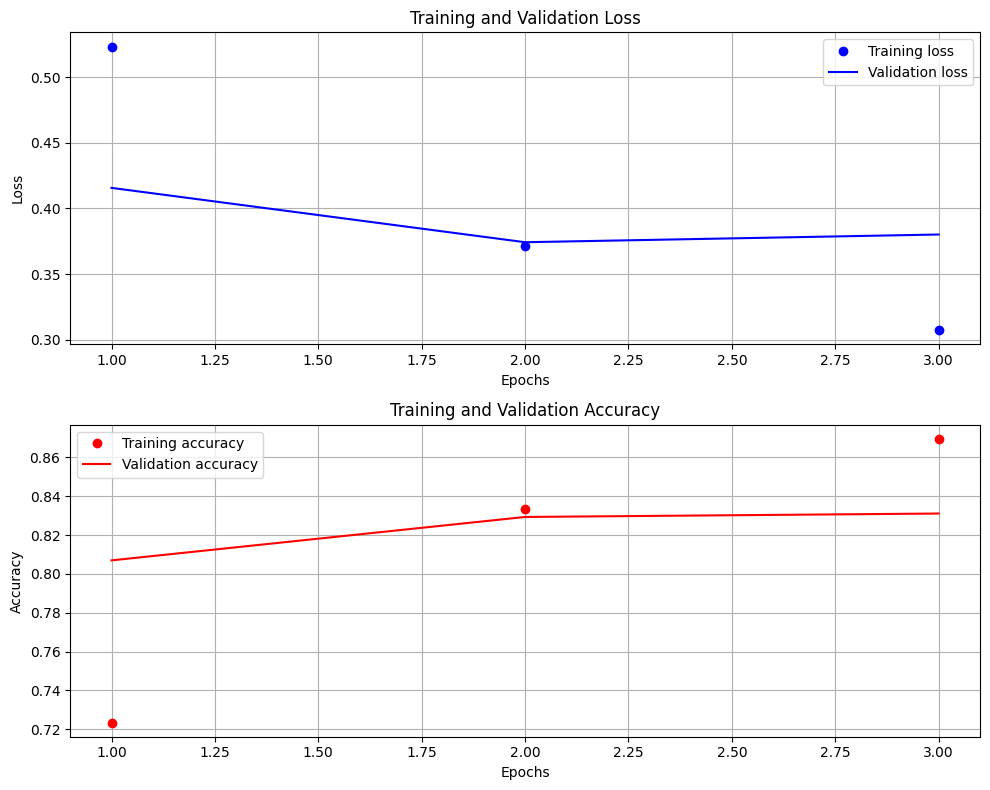

In [15]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 8))  # 전체 Figure 크기 설정

# (1) Loss 그래프
plt.subplot(2, 1, 1)  
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy 그래프
plt.subplot(2, 1, 2)  
plt.plot(epochs_range, train_accs, 'ro', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()  # 그래프 간 간격 자동 조정
plt.show()

In [16]:
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = len(word_to_index)+3
word_vector_dim = 128   
model = Model_3(vocab_size, word_vector_dim)

print(model)

Model_3(
  (embedding): Embedding(10000, 128)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 10   # 10부터 이격이 벌어짐
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\2862455477.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\2862455477.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.long)


Epoch 1/10 - Train Loss: 0.6167, Train Accuracy: 0.6546 - Validation Loss: 0.5341, Validation Accuracy: 0.7296
Epoch 2/10 - Train Loss: 0.4904, Train Accuracy: 0.7621 - Validation Loss: 0.4696, Validation Accuracy: 0.7734
Epoch 3/10 - Train Loss: 0.4297, Train Accuracy: 0.8010 - Validation Loss: 0.4235, Validation Accuracy: 0.8032
Epoch 4/10 - Train Loss: 0.3929, Train Accuracy: 0.8227 - Validation Loss: 0.4042, Validation Accuracy: 0.8150
Epoch 5/10 - Train Loss: 0.3666, Train Accuracy: 0.8369 - Validation Loss: 0.3929, Validation Accuracy: 0.8212
Epoch 6/10 - Train Loss: 0.3486, Train Accuracy: 0.8474 - Validation Loss: 0.3859, Validation Accuracy: 0.8250
Epoch 7/10 - Train Loss: 0.3311, Train Accuracy: 0.8576 - Validation Loss: 0.3808, Validation Accuracy: 0.8288
Epoch 8/10 - Train Loss: 0.3179, Train Accuracy: 0.8649 - Validation Loss: 0.3785, Validation Accuracy: 0.8319
Epoch 9/10 - Train Loss: 0.3047, Train Accuracy: 0.8719 - Validation Loss: 0.3801, Validation Accuracy: 0.8312
E

In [18]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3892, Test Accuracy: 0.8314


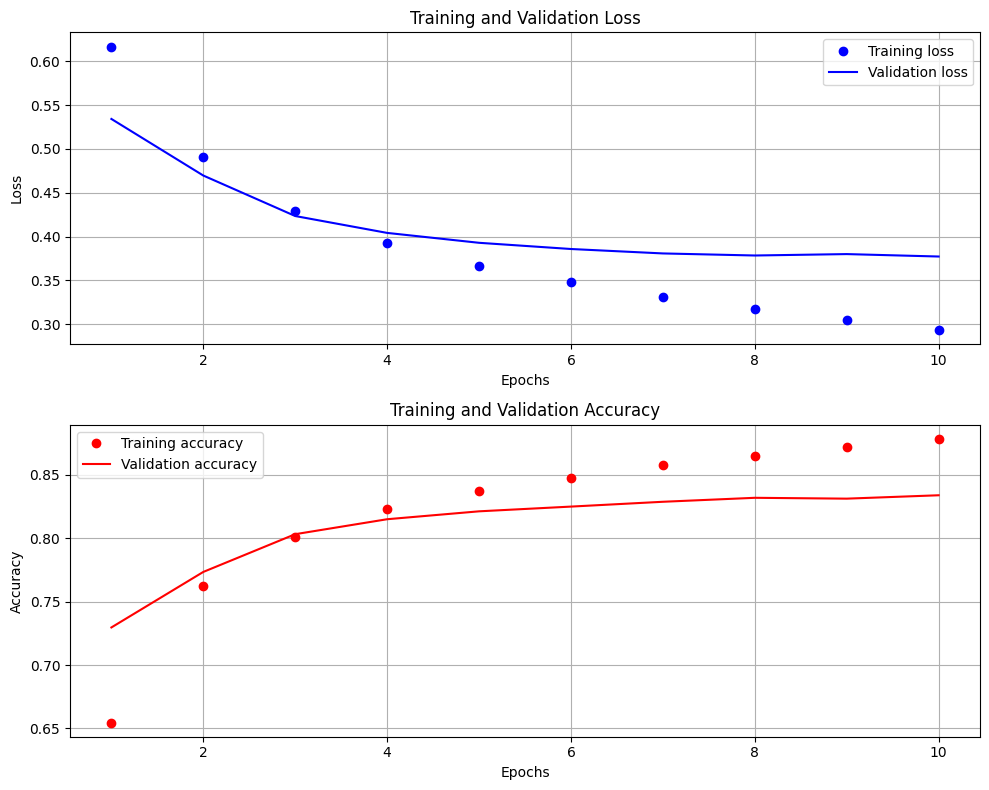

In [19]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 8))  # 전체 Figure 크기 설정

# (1) Loss 그래프
plt.subplot(2, 1, 1)  
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy 그래프
plt.subplot(2, 1, 2)  
plt.plot(epochs_range, train_accs, 'ro', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()  # 그래프 간 간격 자동 조정
plt.show()

- model1 : Test Loss: 0.3530, Test Accuracy: 0.8534
- model2 : Test Loss: 0.3887, Test Accuracy: 0.8280
- model3 : Test Loss: 0.3892, Test Accuracy: 0.8314

# 7) 학습된 임베딩 레이어 분석

In [20]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 128)


In [21]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = "./sentiment_classification/word2vec_emb/word2vec.txt"

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  
    # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 작성

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
    vectors = model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# gensim에서 제공하는 패키지로, 위 셀에서 남긴 임베딩 파라미터를 읽어서 word vector로 활용 가능

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors["행복"]
vector

array([-0.5003763 ,  2.3328726 , -1.881026  , -0.50886714,  0.6134065 ,
        0.73020095, -0.7052367 ,  0.7848564 ,  1.0021814 , -0.942694  ,
       -0.8828742 ,  2.133703  ,  0.59570044,  0.859351  , -0.87617433,
        0.6422653 ,  1.5134104 , -0.7559451 ,  0.8328662 ,  1.135093  ,
       -0.42991728,  0.29989865, -0.80628693,  0.98874927, -0.8665172 ,
        1.0685892 ,  0.1956654 ,  1.0978228 , -0.5086348 , -1.7466037 ,
       -0.3307731 ,  2.325464  , -0.7634814 , -1.1447188 ,  1.173101  ,
       -0.85565615,  0.3881929 ,  0.06308127,  1.5185951 , -0.9924566 ,
        0.39928046, -1.2363096 , -0.8607478 ,  0.8771086 , -0.71947736,
        0.83742785, -0.36311385, -0.16337132,  0.20314243, -0.7135164 ,
       -0.04339976, -0.04157339, -0.12879162,  0.28476214, -1.3478872 ,
        0.26275045,  1.6955818 ,  0.6721038 ,  0.76267153,  1.1160079 ,
       -0.7191391 , -1.345283  , -0.91210955, -0.08480726, -0.32417235,
        0.47484726, -1.1442523 , -0.8151569 ,  0.9766869 ,  1.26

In [23]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하기 위해
# 단어 하나를 주고 그와 가장 유사한 단어와의 유사도를 확인해보기
word_vectors.similar_by_word("행복")

[('이럼', 0.347104012966156),
 ('2011', 0.3216657340526581),
 ('멜로디', 0.2912057340145111),
 ('일요일', 0.28674474358558655),
 ('하여금', 0.28438660502433777),
 ('배트', 0.2830018401145935),
 ('환희', 0.28293493390083313),
 ('어메이징', 0.27725231647491455),
 ('나이', 0.27343273162841797),
 ('느끼', 0.26865682005882263)]

나쁘진... 않은 것 같다..

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [40]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load("./sentiment_classification/data/word2vec_ko.model")
vector = word_vectors.wv["행복"]
vector.shape

(100,)

In [43]:
embedding_matrix = np.zeros((len(word_to_index) + 3, word_vectors.vector_size))

for word, i in word_to_index.items():
    if word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]
    else:
        # 해당 단어가 Word2Vec에 없으면 랜덤 초기화
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(word_vectors.vector_size,))


In [45]:
# 모델 초기화
vocab_size = len(word_to_index) + 3
word_vector_dim = word_vectors.vector_size
model = Model_1(vocab_size, word_vector_dim)

if isinstance(embedding_matrix, np.ndarray):
    embedding_matrix = torch.from_numpy(embedding_matrix).float()

# 임베딩 가중치 덮어쓰기
model.embedding.weight.data.copy_(embedding_matrix)

# (선택) 임베딩을 학습되지 않게 고정
model.embedding.weight.requires_grad = False

In [46]:
from gensim.models import Word2Vec

# Word2Vec 로드
word_vectors = Word2Vec.load("./sentiment_classification/data/word2vec_ko.model")

# 임베딩 매트릭스 생성
embedding_matrix = np.zeros((len(word_to_index) + 3, word_vectors.vector_size))
for word, i in word_to_index.items():
    if word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(word_vectors.vector_size,))

# torch로 변환 후 모델에 주입
embedding_matrix = torch.from_numpy(embedding_matrix).float()
model = Model_1(len(word_to_index)+3, word_vectors.vector_size)
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False  # (원한다면 fine-tuning 해제)


In [47]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 6   # 6부터 이격이 크게 벌어짐
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\21503838.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_X_train_tensor = torch.tensor(partial_X_train, dtype=torch.long)
C:\Users\suhol\AppData\Local\Temp\ipykernel_24024\21503838.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.long)


Epoch 1/6 - Train Loss: 0.5541, Train Accuracy: 0.6909 - Validation Loss: 0.4371, Validation Accuracy: 0.7998
Epoch 2/6 - Train Loss: 0.4155, Train Accuracy: 0.8101 - Validation Loss: 0.4058, Validation Accuracy: 0.8153
Epoch 3/6 - Train Loss: 0.3752, Train Accuracy: 0.8326 - Validation Loss: 0.3877, Validation Accuracy: 0.8254
Epoch 4/6 - Train Loss: 0.3481, Train Accuracy: 0.8464 - Validation Loss: 0.3871, Validation Accuracy: 0.8281
Epoch 5/6 - Train Loss: 0.3340, Train Accuracy: 0.8548 - Validation Loss: 0.3666, Validation Accuracy: 0.8404
Epoch 6/6 - Train Loss: 0.3135, Train Accuracy: 0.8647 - Validation Loss: 0.3581, Validation Accuracy: 0.8405


In [48]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3678, Test Accuracy: 0.8375


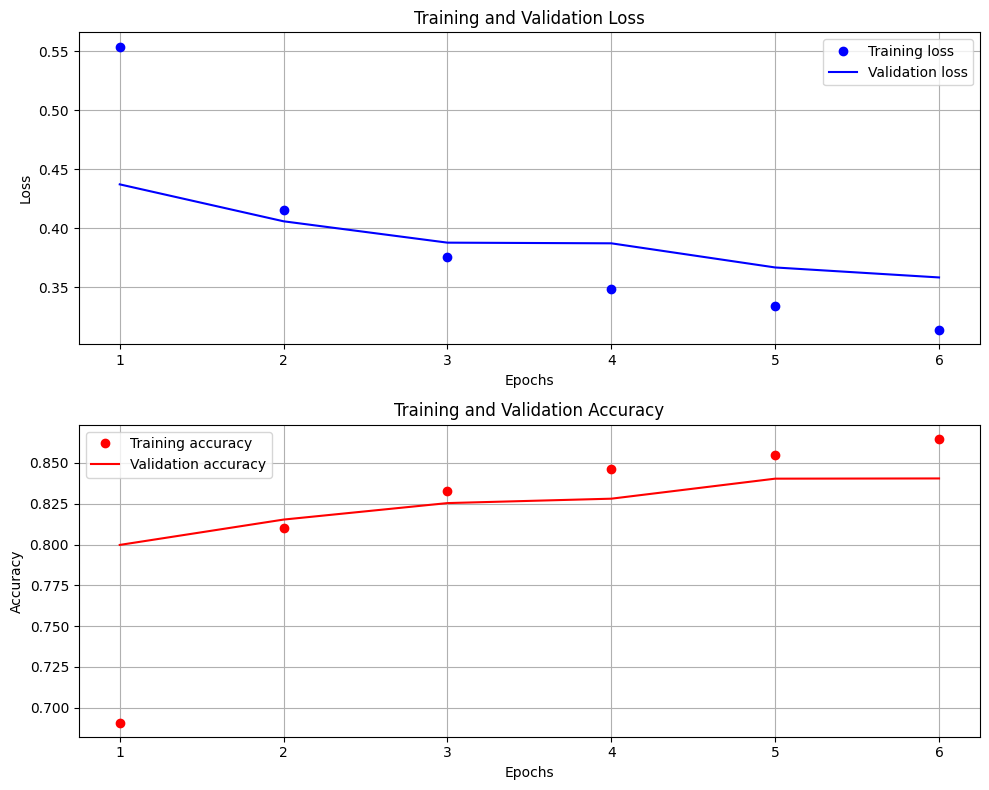

In [49]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 8))  # 전체 Figure 크기 설정

# (1) Loss 그래프
plt.subplot(2, 1, 1)  
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy 그래프
plt.subplot(2, 1, 2)  
plt.plot(epochs_range, train_accs, 'ro', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()  # 그래프 간 간격 자동 조정
plt.show()

#### word2vec X
- model1 : Test Loss: 0.3530, Test Accuracy: 0.8534
- model2 : Test Loss: 0.3887, Test Accuracy: 0.8280
- model3 : Test Loss: 0.3892, Test Accuracy: 0.8314

#### word2vec O
- model1 : Test Loss: 0.3678, Test Accuracy: 0.8375